$$ \huge \text{ Binomial Option Pricing Model} $$
$$ \text{By JZ}$$

### Target : Visualization of the Binomial tree  

#### You need to install graphviz : pip install graphviz
for more info see : https://graphviz.readthedocs.io/en/stable/index.html

# Helper Functions

In [1]:
import logging
import graphviz
import math
import numpy as np
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.INFO)
graphviz.__version__, graphviz.version()

('0.20.3', (2, 50, 0))

In [2]:
class Node:
    '''
      Node to be used in the Binomial tree
    '''
    def __init__(self,name,stock,option_type,strike):
        # info to describe the tree
        self.name = name
        self.parent=None
        self.children=[]

        # info for pricing
        self.option_type=option_type
        self.stock=stock
        self.payoff=None
        self.option= 0.0
        self.delta= 0.0

        if option_type.upper()=="CALL":
            self.payoff=max(stock-strike,0.0)
        elif option_type.upper()=="PUT":
            self.payoff= max(strike-stock,0.0)
  
    def add_child(self,node):
        '''
            Us to express relationship between Nodes
        '''
        node.parent = self
        self.children.append(node)
    
    def __repr__(self):
        '''
        Use for debugging.if you want to call print(node) 
        '''
        return f"{self.name}"

#_________________________________________________________________________________________________________________________________________________

def create_tree(N=3,stock=100.0,vol=0.2,strike=100.0,rate=0.05,option_type="CALL",expiration=1.0,european_style=True):
    '''
        Create the Binomial tree.
        Return the root node.

        time_step = expiration / N 
        u = 1 + vol*sqrt(time_step)
        v = 1 - vol*sqrt(time_step)
        p_prime = 0.5+rate*sqrt(time_step)/(2*vol)
        df = 1.0/(1+rate*time_step)

        two mains steps:
            - forward : compute the stock value at each node using u and v  and the payoff
            - backward: compute the option value at each node using the children nodes
    '''

    # Create the root node - the one that we are going to return 
    root_node = Node(name="S",stock=stock,option_type=option_type,strike=strike)

    # set the variables for the run 
    USflag=0.0
    if not european_style:
        USflag=1.0
    time_step = expiration/float(N)
    u = 1+vol*math.sqrt(time_step)
    v = 1-vol*math.sqrt(time_step)
    p_prime = 0.5+rate*math.sqrt(time_step)/(2.0*vol)
    df = 1.0/(1.0+rate*time_step)
    
    # Generate nodes with u and v : Multiply the stock price by the number of time of u and v required
    # we create a list wich contain list of node at each steps.
    # iteration = 0 : steps_nodes = [ [root] ]
    # iteration = 1 : steps_nodes = [ [root], [uS,dS] ]
    # iteration = 2 : steps_nodes = [ [root], [uS,dS],[uuS,udS,ddS] ]
    # etc...
    
    # Store all the nodes at each steps
    steps_nodes=[[root_node]]

    # Iter on the number of steps 
    for i in range(1,N+1):
        step_nodes=[]
        # Iter on each node at each steps
        for j in range(0,i+1):

           # Generate the name like : uS, dS, uuS, udS, ddS, etc...
           us = ["u"]*(i-j)
           if len(us) < i:
            ds = ["d"]*(i-len(us))
            name = us+ds
           else:
               name = us
           name = ''.join(name)
            
           # compute the value stock
           spot=stock
           for s in name:
               if s=="u":
                   spot*=u
               elif s=="d":
                   spot*=v
                   
           # Create the node 
           node= Node(name+"S",spot,option_type,strike)

           # Save the node in the list of node for the current step 
           step_nodes.append(node)

        # Save the list of the nodes for the current steps
        steps_nodes.append(step_nodes)
    
    # Create links between the nodes
    # iter on the list of list 
    for i in range(0,len(steps_nodes)-1):
          for j in range(0,len(steps_nodes[i])):

              # current node
              node = steps_nodes[i][j]

              # add children
              node.add_child(steps_nodes[i+1][j])
              node.add_child(steps_nodes[i+1][j+1])

    # Init nodes at expiry 
    nodes = steps_nodes[-1]
    for node in nodes:
        node.option = node.payoff

    #_____________________________________________________
    # we initialized the tree:
    #            1- at each node with have the stock value (compute by mutipliying u and d with S)
    #            2- at each node we computed the payoff 
    # Compute Delta and Option  
    for i in range(len(steps_nodes)-2,-1,-1):
        for j in range(0,len(steps_nodes[i])):
                node = steps_nodes[i][j]
                child_1 = node.children[0]
                child_2 = node.children[1]

                # Compute delta  
                node.delta = (child_1.option - child_2.option)/(child_1.stock-child_2.stock)

                # Compute Option 
                node.option =max(df*(p_prime*child_1.option+(1-p_prime)*child_2.option),USflag*node.payoff)
    return root_node         


## Helper functions to represent the Binomial tree with GraphViz

In [3]:
def _add_edges(f,root,visited):
    for node in root.children :
        key= f"{root.name}_{node.name}"
        if key in visited :
                continue
        else:
            visited[key] = 1

        # payoff
        color="grey"
        if node.payoff>0.0:
            color="green"
        if node.payoff<0.0:
            color="black"

        # Option
        color_option="grey"
        if node.option>0.0:
            color_option="green"
        if node.option<0.0:
            color_option="black"
       
        f.node(node.name,label=f'''<<TABLE>
                             <TR>
                               <TD>{node.name}</TD>
                             </TR>
                             <TR>
                               <TD>Stock:{round(node.stock,2)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="{color}">payoff:{round(node.payoff,4)}</TD>
                             </TR>
                             <TR>
                               <TD>delta:{round(node.delta,4)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="{color_option}">Option:{round(node.option,4)}</TD>
                             </TR>

                            </TABLE>>''')
        #f.edge(root.name, node.name, label='p=0.5')
        f.edge(root.name, node.name)
        _add_edges(f,node,visited)

#_________________________________________________________________________________________________________________________________________________

def generate_graph(stock=100.0, vol=0.2,rate=0.05,strike=100.0,option_type="CALL",expiration=1.0,european_style=True,N=4):
    f = graphviz.Digraph('Binomial tree', filename='binomial_option_pricing.gv')
    f.attr(rankdir='LR', size='10')
    f.attr('node', shape='circle')

    # Variable to set 
    time_step = expiration/float(N)
    u = 1+vol*math.sqrt(time_step)
    v = 1-vol*math.sqrt(time_step)
    p_prime = 0.5+rate*math.sqrt(time_step)/(2.0*vol)
    df = round(1.0/(1.0+rate*time_step),4)
    root_node = create_tree(N,stock,vol,strike,rate,option_type,expiration,european_style)

    f.node('S',label=f'''<<TABLE>
                             <TR>
                               <TD>Root</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="orange">stock:{round(stock,2)}</TD>
                             </TR>
                             <TR>
                               <TD>vol:{vol}</TD>
                             </TR>
                             <TR>
                               <TD>strike:{strike}</TD>
                             </TR>
                             <TR>
                               <TD>expiration:{expiration}</TD>
                             </TR>
                             <TR>
                               <TD>european_style:{european_style}</TD>
                             </TR>
                             <TR>
                               <TD>time_step:{time_step}</TD>
                             </TR>
                             <TR>
                               <TD>u:{u}</TD>
                             </TR>
                              <TR>
                               <TD>v:{v}</TD>
                             </TR>
                              <TR>
                               <TD>p_prime:{p_prime}</TD>
                             </TR>
                              <TR>
                               <TD>df:{df}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="orange">payoff:{round(root_node.payoff,4)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="green">delta:{round(root_node.delta,4)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="red">Option:{round(root_node.option,4)}</TD>
                             </TR>
                            </TABLE>>''')
    f.attr('node', shape='circle')
    visited={}
    _add_edges(f,root_node,visited)
    return f 

# Show Graph 

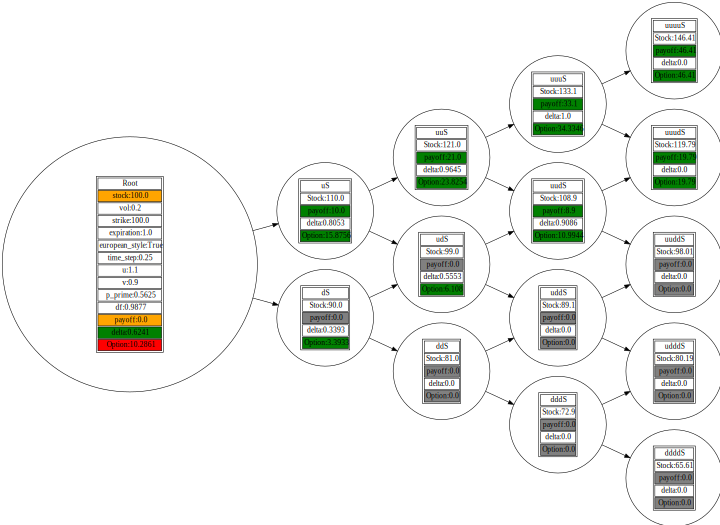

In [4]:
generate_graph(stock=100.0, vol=0.2,rate=0.05,strike=100.0,option_type="CALL",expiration=1.0,european_style=True,N=4)

# Explanation & details for a Call otpion

## Inputs Required :

$$ \text{stock=100.0}$$
$$ \text{vol=20\% }$$
$$ \text{rate=5\%}$$
$$ \text{strike=100.0}$$
$$ \text{expiration =1Y}$$
$$ \text{N=2}$$

## Preparation of the variables:

$$ \text{ $\delta t = \frac{expiration}{N} = \frac{1}{2}$}$$
$$ u = 1+vol*\sqrt{\delta t}$$
$$ v = 1-vol*\sqrt{\delta t}$$
$$ p' = \frac{1}{2}+rate*\frac{ \sqrt{\delta t} }{2*vol}$$
$$ discount\_factor= df = \frac{1}{(1+rate*\delta t)}$$

## Create graph : Iteration 1 - Set Stock price at each node 

### Build graph

In [5]:
# Variables used for the example
stock=100.0
vol=0.2
rate=0.05
strike=100.0
expiration=1.0
N=2

time_step = expiration/float(N)
u = 1+vol*math.sqrt(time_step)
v = 1-vol*math.sqrt(time_step)
p_prime = 0.5+rate*math.sqrt(time_step)/(2.0*vol)
df = round(1.0/(1.0+rate*time_step),4)

#__________________________________________________________________________________________________

def build_graph_iteration_1():
    # Graph 
    f = graphviz.Digraph('Binomial_example', filename='fsm.gv')
    f.attr(rankdir='LR', size='10')
    f.attr('node', shape='circle')
    
    # Root node
    f.node("Root",label=f'''<<TABLE>
                                 <TR>
                                   <TD>Root</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:100.0</TD>
                                 </TR>
                                </TABLE>>''')
    #_________________________________________________________________________________________
    # Level 1 
    #_________________________________________________________________________________________
    
    # node: uS
    f.node("uS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>uS</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock: u*S ={ round( u*stock,4)} </TD>
                                 </TR>
                                </TABLE>>''')
    # node: dS
    f.node("dS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>dS</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock: v*S ={ round( v*stock,4)} </TD>
                                 </TR>
                                </TABLE>>''')
    #_________________________________________________________________________________________
    # Level 2
    #_________________________________________________________________________________________
    
    # node: uuS
    f.node("uuS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>uuS</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock: u*u*S ={ round( u*u*stock,4)} </TD>
                                 </TR>
                                </TABLE>>''')
    # node: udS
    f.node("udS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>udS</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock: u*v*S ={ round( u*v*stock,4)} </TD>
                                 </TR>
                                </TABLE>>''')
    # node: ddS
    f.node("ddS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>ddS</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock: v*v*S ={ round( v*v*stock,4)} </TD>
                                 </TR>
                                </TABLE>>''')
    
    #_________________________________________________________________________________________
    # Create links betweeen them 
    #_________________________________________________________________________________________
    f.edge("Root", "uS")
    f.edge("Root", "dS")
    
    f.edge("uS", "uuS")
    f.edge("uS", "udS")
    
    f.edge("dS", "udS")
    f.edge("dS", "ddS")
    return f

### Show Graph : iteration 1 

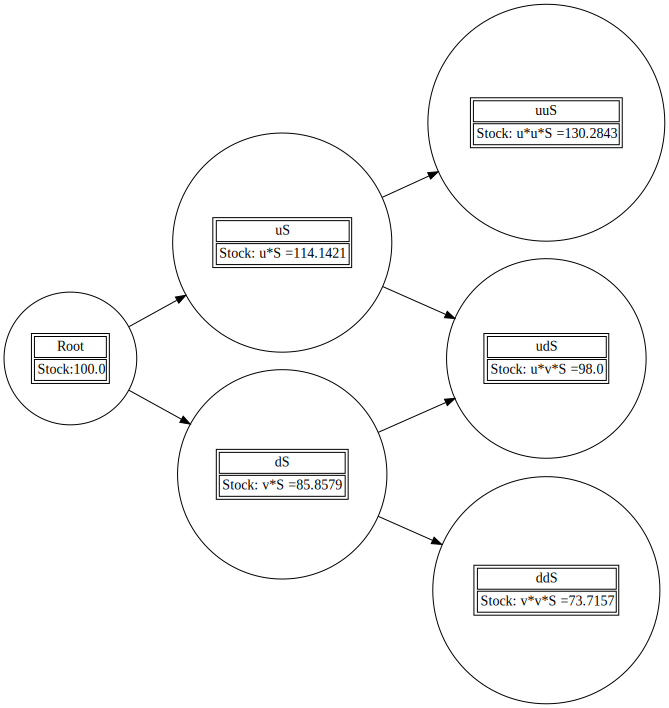

In [6]:
build_graph_iteration_1()

### Update Graph : iteration 2 - compute payoff

### update graph

In [7]:
def build_graph_iteration_2():
    # Graph 
    f = graphviz.Digraph('Binomial_example', filename='fsm.gv')
    f.attr(rankdir='LR', size='10')
    f.attr('node', shape='circle')
    
    # Root node
    f.node("Root",label=f'''<<TABLE>
                             <TR>
                               <TD>Root</TD>
                             </TR>
                             <TR>
                               <TD>Stock:100.0</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="orange">Payoff: max(S-K,0)=0.0</TD>
                             </TR>
                            </TABLE>>''')
    #_________________________________________________________________________________________
    # Level 1 
    #_________________________________________________________________________________________

    # node: uS
    payoff_us = round(max(u*stock - strike,0.0),4)
    stock_us = round( u*stock,4)
    node_label = "uS"
    f.node("uS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}  ={stock_us} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max({stock_us}-{strike},0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff={payoff_us}</TD>
                                 </TR>
                                </TABLE>>''')
    # node: dS
    payoff_ds = round(max(v*stock - strike,0.0),4)
    stock_ds = round( v*stock,4)
    node_label = "dS"
    f.node("dS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}={stock_ds} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= max({stock_ds}-{strike},0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= {payoff_ds}</TD>
                                 </TR>
                                </TABLE>>''')
    #_________________________________________________________________________________________
    # Level 2
    #_________________________________________________________________________________________
    # node: uuS
    payoff_uus = round(max(u*u*stock - strike,0.0),4)
    stock_uus = round( u*u*stock,4)
    node_label = "uuS"
    f.node("uuS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}={stock_uus} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max({stock_uus}-{strike},0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff={payoff_uus}</TD>
                                 </TR>
                                </TABLE>>''')
    
    # node: udS
    payoff_ud = round(max(u*v*stock - strike,0.0),4)
    stock_ud = round( u*v*stock,4)
    node_label = "udS"
    f.node("udS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}={stock_ud} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max({stock_ud}-{strike},0) ={payoff_ud}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff={payoff_ud}</TD>
                                 </TR>
                                </TABLE>>''')
    
    # node: ddS
    payoff_dds = round(max(v*v*stock - strike,0.0),4)
    stock_dds = round( v*v*stock,4)
    node_label = "ddS"
    f.node("ddS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}  ={stock_dds} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= max(S-K,0)</TD>
                                 </TR>
                                  <TR>
                                   <TD bgcolor="orange">Payoff= max({stock_dds}- {strike},0)</TD>
                                 </TR>
                                  <TR>
                                   <TD bgcolor="orange">Payoff={payoff_dds}</TD>
                                 </TR>
                                </TABLE>>''')
    #_________________________________________________________________________________________
    # Create links betweeen them 
    #_________________________________________________________________________________________
    f.edge("Root", "uS")
    f.edge("Root", "dS")
    
    f.edge("uS", "uuS")
    f.edge("uS", "udS")
    
    f.edge("dS", "udS")
    f.edge("dS", "ddS")
    return f


### Show Graph : iteration 2 - payoff 

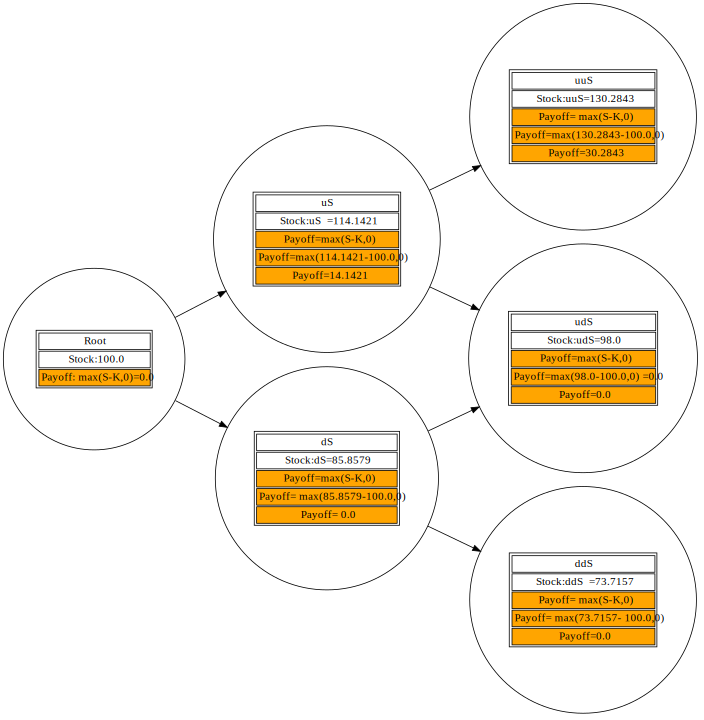

In [8]:
build_graph_iteration_2()

### Update Graph : iteration 3 - Backward :compute Delta and Option Values

In [9]:
def build_graph_iteration_3():
    ''' Backward construction'''
    stock=100.0
    vol=0.2
    rate=0.05
    strike=100.0
    expiration=1.0
    N=2
    
    time_step = expiration/float(N)
    u = 1+vol*math.sqrt(time_step)
    v = 1-vol*math.sqrt(time_step)
    p_prime = 0.5+rate*math.sqrt(time_step)/(2.0*vol)
    df = round(1.0/(1.0+rate*time_step),4)
        
    # Graph 
    f = graphviz.Digraph('Binomial_example', filename='fsm.gv')
    f.attr(rankdir='LR', size='10')
    f.attr('node', shape='circle')

    
    #_________________________________________________________________________________________
    # Level 2
    #_________________________________________________________________________________________
    # node: uuS
    payoff_uus = round(max(u*u*stock - strike,0.0),4)
    stock_uus = round( u*u*stock,4)
    node_label = "uuS"
    option_uus = payoff_uus
    f.node("uuS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}={stock_uus} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max({stock_uus}-{strike},0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff={payoff_uus}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="green">Delta: Not Available</TD>
                                 </TR>
                                 <TR>
                                   <TD  bgcolor="cyan">Option = Payoff = {payoff_uus}</TD>
                                 </TR>
                                </TABLE>>''')
    
    # node: udS
    payoff_uds = round(max(u*v*stock - strike,0.0),4)
    stock_uds = round( u*v*stock,4)
    node_label = "udS"
    option_uds = payoff_uds
    f.node("udS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}={stock_uds} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max({stock_uds}-{strike},0) ={payoff_uds}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff={payoff_uds}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="green">Delta: Not Available</TD>
                                 </TR>
                                 <TR>
                                   <TD  bgcolor="cyan">Option = Payoff = {payoff_uds}</TD>
                                 </TR>
                                </TABLE>>''')
    
    # node: ddS
    payoff_dds = round(max(v*v*stock - strike,0.0),4)
    stock_dds = round( v*v*stock,4)
    node_label = "ddS"
    option_dds = payoff_dds
    f.node("ddS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}  ={stock_dds} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= max(S-K,0)</TD>
                                 </TR>
                                  <TR>
                                   <TD bgcolor="orange">Payoff= max({stock_dds}- {strike},0)</TD>
                                 </TR>
                                  <TR>
                                   <TD bgcolor="orange">Payoff={payoff_dds}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="green">Delta: Not Available</TD>
                                 </TR>
                                 <TR>
                                   <TD  bgcolor="cyan">Option = Payoff = {payoff_dds}</TD>
                                 </TR>
                                </TABLE>>''')

    #_________________________________________________________________________________________
    # Level 1 
    #_________________________________________________________________________________________
    # node: uS
    payoff_us = round(max(u*stock - strike,0.0),4)
    stock_us = round( u*stock,4)
    node_label = "uS"
    delta_us = round((option_uus -option_uds ) /(stock_uus-stock_uds),4)
    option_us = round(max(df*(p_prime*option_uus+(1-p_prime)*option_uds),0.0),4)
    f.node("uS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}  ={stock_us} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max({stock_us}-{strike},0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff={payoff_us}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="green">Delta=(option_uus -option_uds )/(stock_uus-stock_uds)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="green">Delta={delta_us}</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="cyan">Option=max(df*(p_prime*option_uus+(1-p_prime)*option_uds),0.0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="cyan">Option=max({round(df,2)}*({round(p_prime,2)}*{option_uus}+(1-{round(p_prime,2)})*{option_uds}),0.0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="cyan">Option={option_us}</TD>
                                 </TR>
                                </TABLE>>''')
    # node: dS
    payoff_ds = round(max(v*stock - strike,0.0),4)
    stock_ds = round( v*stock,4)
    node_label = "dS"
    delta_ds = round((option_uds - option_dds ) /(stock_uds-stock_dds),4)
    option_ds = round(max(df*(p_prime*option_uds+(1-p_prime)*option_dds),0.0),4)
    f.node("dS",label=f'''<<TABLE>
                                 <TR>
                                   <TD>{node_label}</TD>
                                 </TR>
                                 <TR>
                                   <TD>Stock:{node_label}={stock_ds} </TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff=max(S-K,0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= max({stock_ds}-{strike},0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="orange">Payoff= {payoff_ds}</TD>
                                 </TR>
                                  <TR>
                                   <TD bgcolor="green">Delta=(option_uds -option_dds ) /(stock_uds-stock_dds)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="green">Delta={delta_ds}</TD>
                                 </TR>
                                  <TR>
                                   <TD bgcolor="cyan">Option=max(df*(p_prime*option_uds+(1-p_prime)*option_dds),0.0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="cyan">Option=max({round(df,2)}*({round(p_prime,2)}*{option_uds}+(1-{round(p_prime,2)})*{option_dds}),0.0)</TD>
                                 </TR>
                                 <TR>
                                   <TD bgcolor="cyan">Option={option_ds}</TD>
                                 </TR>
                                </TABLE>>''')
      
    # Root node
    delta_root = round((option_us - option_ds ) /(stock_us-stock_ds),4)
    option_root = round(max(df*(p_prime*option_us+(1-p_prime)*option_ds),0.0),4)
    f.node("Root",label=f'''<<TABLE>
                             <TR>
                               <TD>Root</TD>
                             </TR>
                             <TR>
                               <TD>Stock:100.0</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="orange">Payoff: max(S-K,0)=0.0</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="green">Delta=(option_us -option_ds ) /(stock_us-stock_ds)</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="green">Delta={delta_root}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="cyan">Option=max(df*(p_prime*option_us+(1-p_prime)*option_ds),0.0)</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="cyan">Option=max({round(df,2)}*({round(p_prime,2)}*{option_us}+(1-{round(p_prime,2)})*{option_ds}),0.0)</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="cyan">Option={option_root}</TD>
                             </TR>
                             </TABLE>>''')
 
    #_________________________________________________________________________________________
    # Create links betweeen them 
    #_________________________________________________________________________________________
    f.edge("Root", "uS")
    f.edge("Root", "dS")
    
    f.edge("uS", "uuS")
    f.edge("uS", "udS")
    
    f.edge("dS", "udS")
    f.edge("dS", "ddS")

    #________________________________________________________________________________________________________________________________
    # Backward links to compute Delta and Option pricing  
    #_________________________________________________________________________________________
    arrow_size="3"
    f.edge("uS","Root",color="green",constraint="false",arrowsize=arrow_size)
    f.edge("dS","Root", color="green",constraint="false",arrowsize=arrow_size)
    
    f.edge("uuS","uS", color="green",constraint="false",arrowsize=arrow_size)
    
    f.edge("udS","uS", color="green",constraint="false",arrowsize=arrow_size)
    f.edge("udS","dS", color="green",constraint="false",arrowsize=arrow_size)
    
    f.edge("ddS","dS", color="green",constraint="false",arrowsize=arrow_size)
    
    stock=100.0
    return f

### update graph

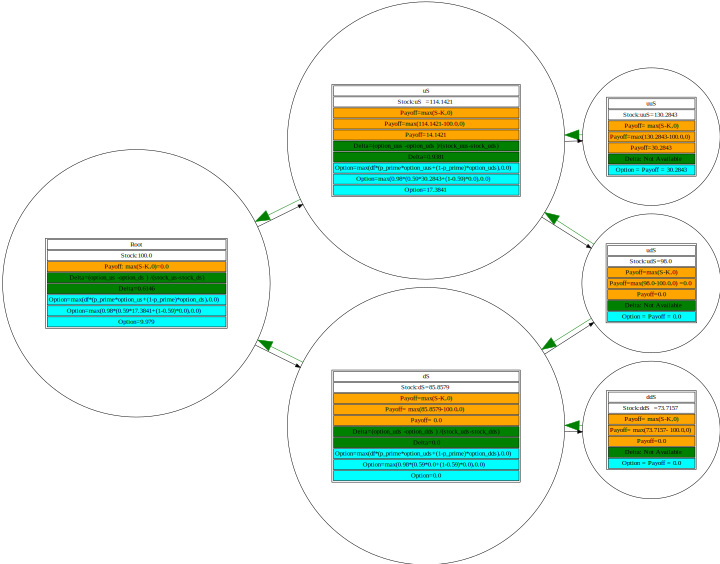

In [10]:
build_graph_iteration_3()

# Without Visualization : Formula 

### see : https://www.codearmo.com/python-tutorial/options-trading-binomial-pricing-model

In [15]:
def compute_call(N=4,stock=100.0,expiry=0.5,vol=0.4,strike=105,rate=0.05): 
    ############params################
    S0  = stock
    T = expiry
    sigma = vol
    dt = T/N
    K = strike
    r = rate
    
    u = np.exp( sigma * np.sqrt(dt) )
    d =  np.exp( -sigma * np.sqrt(dt) )
    p = ( np.exp(r*dt) - d) / (u -d)

    print(f"u={u}")
    print(f"d={d}")
    
    
    ######showing terminal stock prices for 4 step model################
    # for k in reversed(range(N+1)):
    #     ST = S0 * u**k * d ** (N-k)
    #     print(round(ST,2), round(max(ST-K,0),2))
        
    ############showing node probabilities
    def combos(n, i):
        return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))
    
    # for k in reversed(range(N+1)):
    #     p_star = combos(N, k)*p**k *(1-p)**(N-k)
    #     print(round(p_star,2))
    
    ######valuing the call from example#######################
    C=0   
    for k in reversed(range(N+1)):
        p_star = combos(N, k)*p**k *(1-p)**(N-k)
        ST = S0 * u**k * d ** (N-k)
        C += max(ST-K,0)*p_star
    res = np.exp(-r*T)*C
    return res

In [16]:
compute_call(N=4,stock=100.0,expiry=1,vol=0.2,strike=100,rate=0.05)

u=1.1051709180756477
d=0.9048374180359595


9.970522921901265

In [21]:
N =100
S0  = 100.0
T = 1.0
sigma = 0.2
K = 100.0
r = 0.05

def combos(n, i):
        return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))
    
def binom_EU1(S0, K , T, r, sigma, N, type_ = 'call'):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (  np.exp(r*dt) - d )  /  (  u - d )
    value = 0 
    for i in range(N+1):
        node_prob = combos(N, i)*p**i*(1-p)**(N-i)
        ST = S0*(u)**i*(d)**(N-i)
        if type_ == 'call':
            value += max(ST-K,0) * node_prob
        elif type_ == 'put':
            value += max(K-ST, 0)*node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'" )
    
    return value*np.exp(-r*T)


binom_EU1(S0, K, T, r,sigma, N)

10.430611662249119